# Feature selection
- Compare performance of different molecule and zeolite feature sets on a single model.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem 
from rdkit.Chem import Draw

# remove warning messages 
import warnings
warnings.filterwarnings("ignore")

# Plotting functions 

In [2]:
cm = 1/2.54  # centimeters in inches

def show_mols(smis, legend=None, molsperrow=10, maxmols=50, subimgsize=(200, 200)):
    '''Show molecules in a grid.'''
    mols = [Chem.MolFromSmiles(smi) for smi in smis]
    if not legend:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
        )
    else:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
            legends=legend,
        )
    return img

def save_mpl_fig(fig, basename, ending='.pdf', dpi=300):
    fig.savefig(basename + ending, bbox_inches='tight', dpi=dpi)

def format_axs(
    axs,
    xtick_size,
    ytick_size,
    spines_width,
    xlabel,
    ylabel,
    xlabel_size,
    ylabel_size,
    limits=None,
    tick_width=2, 
    tick_size=6, 
    bold_axs=False,
    weight=None,
    xticks=None,
    yticks=None,
):
    
    if bold_axs:
        weight = 'bold'

    # Set tick labels
    if xticks is not None:
        axs.set_xticks(xticks)
    if yticks is not None:
        print('boo')
        print(yticks)
        axs.set_yticks(yticks)

    axs.tick_params(axis="x", which="major", labelsize=xtick_size)
    axs.tick_params(axis="y", which="major", labelsize=ytick_size)
    axs.xaxis.set_tick_params(width=tick_width, size=tick_size)
    axs.yaxis.set_tick_params(width=tick_width, size=tick_size)

    # Bold the tick labels
    print(axs.get_yticklabels())
    axs.set_xticklabels(axs.get_xticklabels(), fontweight=weight)
    axs.set_yticklabels(axs.get_yticklabels(), fontweight=weight)
    
    # axs.tick_params(axis='both', which='minor="something", labelsize=8)
    for axis in ["top", "bottom", "left", "right"]:
        axs.spines[axis].set_linewidth(spines_width)

    axs.set_xlabel(xlabel, fontsize=xlabel_size, weight=weight)
    axs.set_ylabel(ylabel, fontsize=ylabel_size, weight=weight)
    
    if not limits:
        return axs
    if "x" in limits.keys():
        axs.set_xlim(limits["x"])
    if "y" in limits.keys():
        axs.set_ylim(limits["y"])
    
    return axs

def get_cb(fig, sc, axs, label, ticks=None, linewidth=2, tickwidth=2, labelsize=18, labelpad=20):
    '''Get colorbar'''
    cb = fig.colorbar(sc, ax=axs)
    cb.set_label(label, fontsize=labelsize)
    cb.outline.set_linewidth(linewidth)
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.ax.tick_params(width=tickwidth)
    cb.ax.tick_params(labelsize=labelsize)
    # pad
    cb.ax.xaxis.labelpad = labelpad
    return cb

def get_legend(
    fig,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=15,
    loc="upper center",
    ncol=2,
    axs=None,
    format_handles=False,
    legend_colors=None,
    linewidth=2,
    edgecolor="k",
    put_where="fig",
):
    '''Get legend.'''
    positions = {"fig": fig, "axs": axs}
    legend = positions[put_where].legend(
        fontsize=fontsize,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncol=ncol,
        frameon=False,
    )

    if format_handles:
        for idx, handle in enumerate(legend.legendHandles):
            handle.set_color(legend_colors[idx])
            handle.set_linewidth(linewidth)
            handle.set_edgecolor(edgecolor)

    return legend
    
def get_color_values(num_colors, c="viridis"):
    '''Get a list of color values from a colormap'''
    cmap = plt.cm.get_cmap(c)
    color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return color_values

def draw_parity(axs, xlimits, ylimits, lw=1):
    '''Draw a parity line on a plot'''
    limits = [min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1])]
    axs.plot(limits, limits, "k--", lw=lw)
    return axs

# Utility cells

In [3]:
run_to_fs_mol = {    
    2: 'Physical',
    3: 'Morgan fps',
    4: 'WHIM fps',
    5: 'GETAWAY fps',
    6: 'Axes',
    7: 'Box',
    8: '3D MORSE fps',
    # 9: 'Morgan + physical',
    }

run_to_fs_fws = {
    2: 'Physical',
    9: 'Physical (extended)',
    10: 'PSD',
    11: 'PH',
    12: 'OHE',
    13: 'SOAP',
    14: 'PSD moments',
    15: 'Ray',
    16: 'Ray moments',
}

mol_runs_in_desired_order = [2, 3, 8, 5, 4, 7, 6]
# phys, Morgan, 3D MORSE, GETAWAY, WHIM, Box, Axes
# physical, 2D, then abstract fps in decreasing length 

fw_runs_in_desired_order = [2, 9, 12, 10, 14, 15, 16, 13, 11]
# phys, phys long, OHE, PSD, PSD mom, Ray, Ray mom, SOAP, PH
# increasing abstractness

# Read results file

In [4]:
results = pd.read_csv("../data/publication/results.csv")
print(results.columns, results.shape)

Index(['task', 'run', 'fold', 'train_loss', 'val_loss', 'test_loss',
       'train_loss_unscaled', 'val_loss_unscaled', 'test_loss_unscaled'],
      dtype='object') (315, 9)


# Plot

## Molecular feature sets

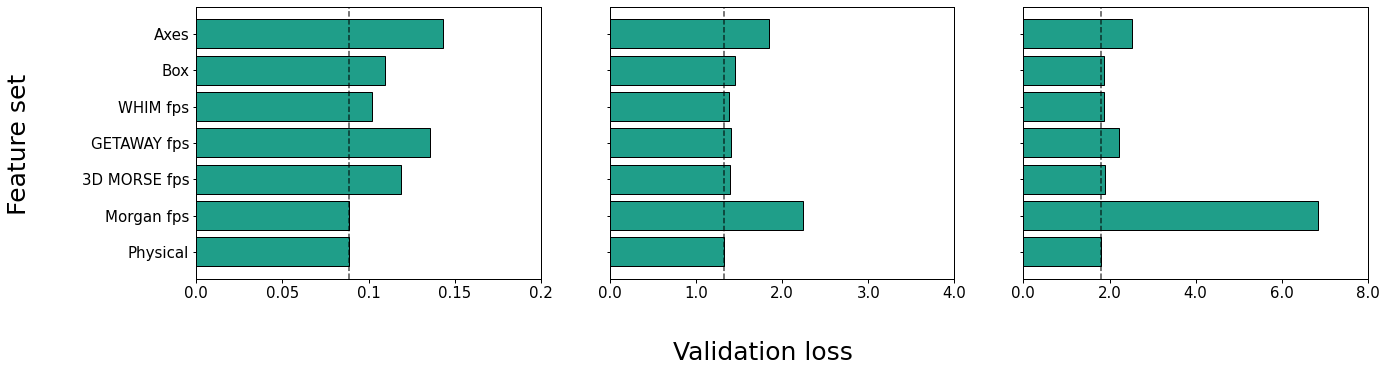

In [23]:
def create_bar_chart(x, y, ax, bar_kwargs, tick_width=1, tick_size=20, label_size=20, spines_width=1, weight=None, limits=None, xticks=None):

    ax.barh(x, y, **bar_kwargs)
    ax.tick_params(axis="both", which="major", labelsize=tick_size, width=tick_width)
    if xticks is None:
        ax.set_xticklabels(ax.get_xticks(), fontsize=label_size, weight=weight)
    else:
        ax.set_xticklabels(xticks, fontsize=label_size, weight=weight)
    ax.set_yticklabels(x, fontsize=label_size, weight=weight)
    
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(spines_width)
    
    if limits:
        if "x" in limits.keys():
            ax.set_xlim(limits["x"])
        if "y" in limits.keys():
            ax.set_ylim(limits["y"])
    
    # add vertical dotted line to indicate the best model
    lowest = min(y)
    axs[idx].axvline(lowest, color='k', linestyle='--', alpha=0.7);

    return ax

# set x axis limits 
binary_limits = dict(x=[0.0, 0.2])
energy_limits = dict(x=[0.0, 4.0])
mclass_limits = dict(x=[0, 8])
limits = [binary_limits, energy_limits, mclass_limits]

fig, axs = plt.subplots(1, 3, figsize=(21, 5))

for idx, task in enumerate(['binary', 'energy', 'mclass']):
    # get data
    dd = results[results.task == task] 
    dd = dd[dd.run.isin(run_to_fs_mol.keys())]
    dd = dd.groupby('run').mean()
    dd = dd.sort_index()

    # set ordering of feature set
    x = [run_to_fs_mol[i] for i in mol_runs_in_desired_order]
    y = dd.loc[mol_runs_in_desired_order].val_loss_unscaled

    # plot
    colors = get_color_values(10)
    barkwargs = dict(color=colors[5], alpha=1.0, edgecolor='k')
    xticks = [round(x,2) for x in np.linspace(
        limits[idx]['x'][0], 
        limits[idx]['x'][1], 
        5
        )]

    axs[idx] = create_bar_chart(x, y, axs[idx], bar_kwargs=barkwargs, tick_width=1, tick_size=15, label_size=15, spines_width=1, limits=limits[idx], xticks=xticks)
    
    if idx != 0:
        axs[idx].set_yticklabels([])
        axs[idx].set_ylabel("")
    axs[idx].set_xlabel("")

# Add figure y axis and x axis
fs = 25
fig.text(0.5, -0.1, 'Validation loss', ha='center', fontsize=fs);
fig.text(0.0, 0.5, 'Feature set', va='center', rotation='vertical', fontsize=fs);

## Framework feature sets

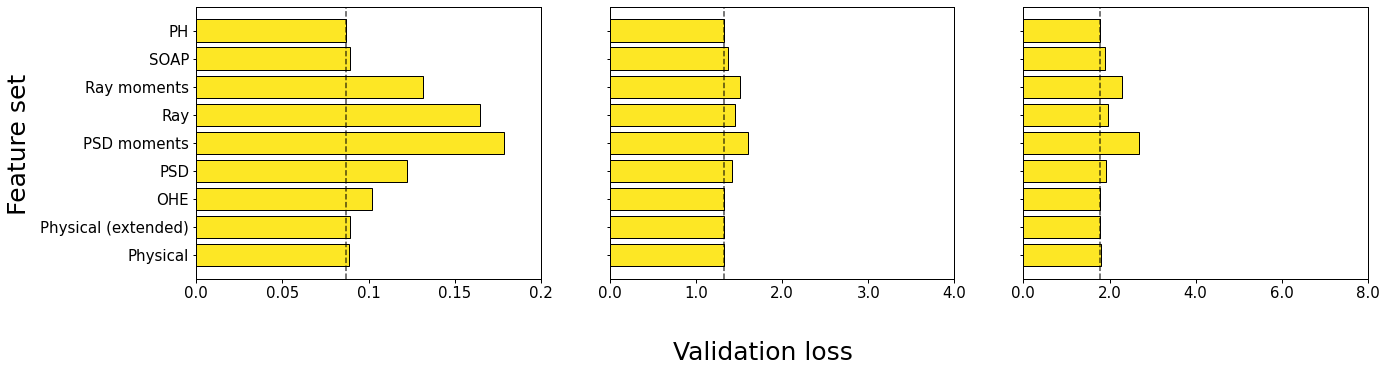

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

for idx, task in enumerate(['binary', 'energy', 'mclass']):
    # get data
    dd = results[results.task == task] 
    dd = dd[dd.run.isin(run_to_fs_fws.keys())]
    dd = dd.groupby('run').mean()
    dd = dd.sort_index()

    # set ordering of feature set
    x = [run_to_fs_fws[i] for i in fw_runs_in_desired_order]
    y = dd.loc[fw_runs_in_desired_order].val_loss_unscaled

    # plot
    colors = get_color_values(5)
    barkwargs = dict(color=colors[4], alpha=1.0, edgecolor='k')
    xticks = [round(x,2) for x in np.linspace(
        limits[idx]['x'][0], 
        limits[idx]['x'][1], 
        5
        )]

    axs[idx] = create_bar_chart(x, y, axs[idx], bar_kwargs=barkwargs, tick_width=1, tick_size=15, label_size=15, spines_width=1, limits=limits[idx], xticks=xticks)
    
    if idx != 0:
        axs[idx].set_yticklabels([])
        axs[idx].set_ylabel("")
    axs[idx].set_xlabel("")

# Add figure y axis and x axis
fs = 25
fig.text(0.5, -0.1, 'Validation loss', ha='center', fontsize=fs);
fig.text(0.0, 0.5, 'Feature set', va='center', rotation='vertical', fontsize=fs);